# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time

/tmp/ipykernel_3425515/3878399115.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
# warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg')
import memento

In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'
data_path = '/data_volume/memento/hbec/'

### Perform some basic filtering

In [10]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')


### Setup memento

In [11]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [12]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [13]:
memento.setup_memento(adata, q_column='q')

### WT cytokine variability

In [14]:
adata.obs.cell_type.value_counts()

cell_type
basal/club       29792
basal            22844
ciliated         15041
goblet            1525
ionocyte/tuft      546
neuroendo          210
Name: count, dtype: int64

In [15]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [16]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

In [19]:
ctrl = adata[(adata.obs.stim=='control') & (adata.obs.ct.isin(['B', 'BC', 'C']))].copy().copy()
ctrl.obs['group'] = 1
memento.create_groups(ctrl, label_columns=['ct', 'donor'])
memento.compute_1d_moments(ctrl, min_perc_group=.3)

m_df, v_df = memento.get_1d_moments(ctrl, groupby='ct')

cytokines = pd.read_csv('cytokines.txt')['Gene name'].tolist()
m_df['cytokine'] = m_df['gene'].isin(cytokines)
v_df['cytokine'] = v_df['gene'].isin(cytokines)
cytokines = v_df.query('cytokine').gene.tolist()

In [20]:
v_df_melt = v_df.melt(['gene', 'cytokine'], m_df.columns[1:-1])
m_df_melt = m_df.melt(['gene', 'cytokine'], m_df.columns[1:-1])

(-3.5, 4.0)

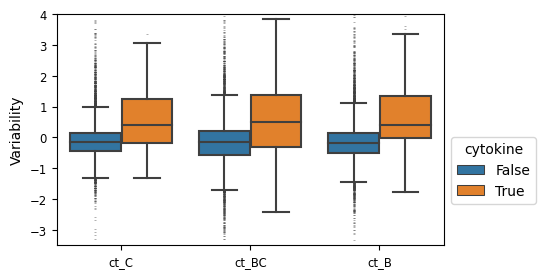

In [21]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='cytokine',data=v_df_melt, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,0.5), title='cytokine'); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-3.5,4)

### Identify IFNB ISGs

In [22]:
ct = adata[(adata.obs.ct=='C') & adata.obs.time.isin(['0', '6']) & adata.obs.stim.isin(['control', 'beta'])].copy().copy()
ct.obs['stim_indicator'] = (ct.obs['stim']=='beta').astype(int)
memento.create_groups(ct, label_columns=['stim_indicator', 'donor'])
memento.compute_1d_moments(ct, min_perc_group=.9)

meta_df = memento.get_groups(ct)
treatment = meta_df[['stim_indicator']]
covariate = pd.get_dummies(meta_df[['donor']], drop_first=True)

memento.ht_1d_moments(
        ct, 
        covariate=covariate,
        treatment=treatment,
        num_boot=10000, 
        verbose=1,
        num_cpus=14,
        resample_rep=False,
        approx=False)


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.0s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    6.6s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   13.1s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   22.3s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   33.5s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   46.6s
[Parallel(n_jobs=14)]: Done 2422 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 3172 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done 4972 tasks      | elapsed:  2.1min
[Parallel(n_jobs=14)]: Done 6022 tasks      | elapsed:  2.6min
[Parallel(n_jobs=14)]: Done 7172 tasks      | elapsed:  3.1min
[Parallel(n_jobs=14)]: Done 8422 tasks      | elapsed:  3.6min
[Parallel(n_jobs=14)]: Done 9679 out of 9679 | elapsed:  4.2min finished


In [297]:
ct_df = memento.get_1d_ht_result(ct)
ct_df['de_fdr'] = memento.util._fdrcorrect(ct_df['de_pval'])
ifnb_isg = ct_df.query('de_coef > 1 & de_fdr < 0.1').gene.tolist()

### Do the same thing for ISGs

In [298]:
def get_labeled_variability(adata, key):
    
    m_df, v_df = memento.get_1d_moments(adata, groupby=key)
    
    m_df['cytokine'] = m_df['gene'].isin(cytokines)
    v_df['cytokine'] = v_df['gene'].isin(cytokines)
    m_df['ifnb_isg'] = m_df['gene'].isin(ifnb_isg)
    v_df['ifnb_isg'] = v_df['gene'].isin(ifnb_isg)
    ifnb_isg_ctrl = m_df.query('ifnb_isg').gene.tolist()
    
    v_df_melt = v_df.melt(['gene', 'cytokine', 'ifnb_isg'], v_df.columns[1:-2])
    m_df_melt = m_df.melt(['gene', 'cytokine', 'ifnb_isg'], m_df.columns[1:-2])
    
    return m_df_melt, v_df_melt

In [299]:
hbec_m, hbec_v = get_labeled_variability(ctrl, 'ct')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimat

(-3.5, 4.0)

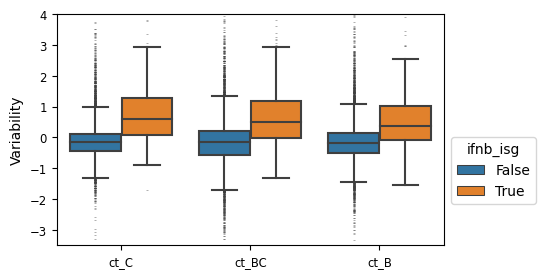

In [300]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='ifnb_isg',data=hbec_v, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,0.5), title='ifnb_isg'); 
plt.ylabel('Variability'); plt.xlabel(None)
plt.ylim(-3.5,4)

### Do the same in PBMCs

In [301]:
pbmc = sc.datasets.pbmc3k_processed()
pbmc = sc.AnnData(X=pbmc.raw.X.expm1(), obs = pbmc.obs, var=pbmc.raw.var)

In [302]:
pbmc.obs['group'] = 1
pbmc.obs['q'] = 0.1
memento.setup_memento(pbmc, q_column='q')
memento.create_groups(pbmc, label_columns=['louvain'])
memento.compute_1d_moments(pbmc, min_perc_group=.3)

pbmc_m, pbmc_v = get_labeled_variability(pbmc, 'louvain')

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.10.egg/memento/main.py:563: RuntimeWarning: divide by zero encountered in log
  moment_mean_df[group] = np.log(val[0])
/home/ssm-user/Github/scrna-parameter-estimat

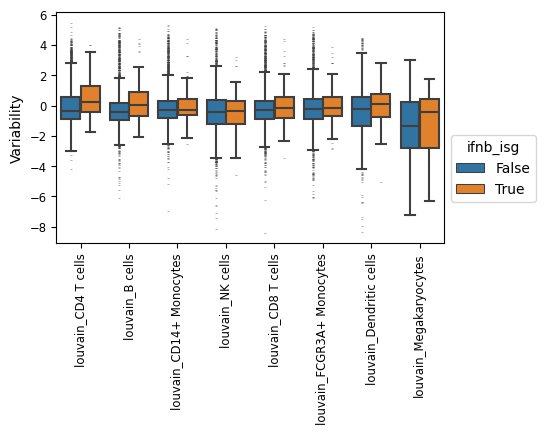

In [303]:
plt.figure(figsize=(5,3))
sns.boxplot(x='variable', y='value', hue='ifnb_isg',data=pbmc_v, fliersize=0.1)
plt.legend(bbox_to_anchor=(1,0.5), title='ifnb_isg'); 
plt.ylabel('Variability'); plt.xlabel(None); plt.xticks(rotation=90);
# plt.ylim(-3.5,4)

### All gene correlations

In [304]:
def get_ct_correlation(df, ct1, ct2, s=5, color='grey', alpha=1):
    
    df1 = df.query('variable == "{}"'.format(ct1))
    df2 = df.query('variable == "{}"'.format(ct2))
    joined = df1.merge(df2, on='gene')
    # print(joined)
    plt.scatter(x=joined.dropna()['value_x'], y=joined.dropna()['value_y'],s=s, color=color, alpha=alpha)
    # r,p = stats.pearsonr(joined.dropna()['value_x'], joined.dropna()['value_y'])
    # plt.title('R={:.2f}, p={:.2f}'.format(r,p))
    # plt.xlabel(ct1.split('_')[1]);plt.ylabel(ct2.split('_')[1])
    

In [305]:
all_v = pd.concat([pbmc_v, hbec_v])
isg_v = pd.concat([pbmc_v.query('ifnb_isg'), hbec_v.query('ifnb_isg')])
hbec_cts, pbmc_cts = hbec_v.variable.drop_duplicates().tolist(), pbmc_v.variable.drop_duplicates().tolist()

In [306]:
pbmc_cts

['louvain_CD4 T cells',
 'louvain_B cells',
 'louvain_CD14+ Monocytes',
 'louvain_NK cells',
 'louvain_CD8 T cells',
 'louvain_FCGR3A+ Monocytes',
 'louvain_Dendritic cells',
 'louvain_Megakaryocytes']

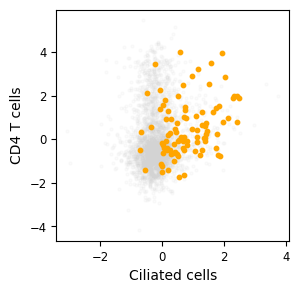

In [312]:
plt.figure(figsize=(3, 3));
plt.subplots_adjust(wspace=0.6, hspace=0.8)
# idx=1
for c1, c2 in itertools.product(['ct_C'], ['louvain_CD4 T cells']):
    

    get_ct_correlation(all_v, c1, c2, s=5, color='lightgrey', alpha=0.08)
    get_ct_correlation(isg_v, c1, c2, s=10, color='orange')
    plt.xlabel('Ciliated cells'); plt.ylabel(c2.split('_')[1])
    # plt.axhline(y=0, color='k',ls='--')
    # plt.axvline(x=0, color='k', ls='--')
    
    # if idx == 3:
    #     plt.title('Expression variablities across cell types')
    # idx +=1 

plt.savefig('c_cd4_variabilities.png', dpi=100, bbox_inches='tight')

ct_C louvain_CD4 T cells
ct_C louvain_B cells
ct_C louvain_CD14+ Monocytes
ct_C louvain_NK cells
ct_C louvain_CD8 T cells
ct_C louvain_Dendritic cells


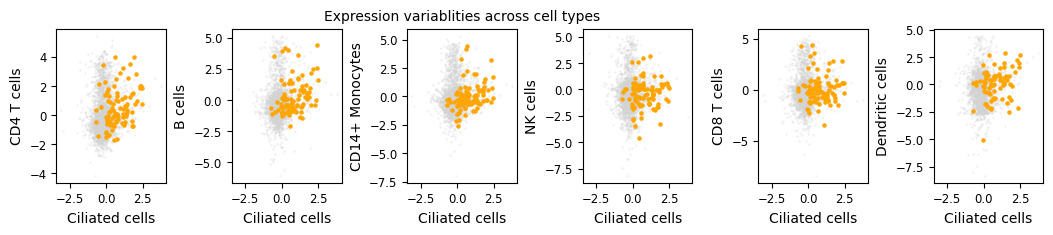

In [278]:
plt.figure(figsize=(15, 2));
plt.subplots_adjust(wspace=0.6, hspace=0.8)
idx=1
for c1, c2 in itertools.product(['ct_C'], pbmc_cts[:5] + ['louvain_Dendritic cells']):
    
    print(c1, c2)
    plt.subplot(1, 7, idx)
    
    get_ct_correlation(all_v, c1, c2, s=1, color='lightgrey', alpha=0.2)
    get_ct_correlation(isg_v, c1, c2, s=5, color='orange')
    plt.xlabel('Ciliated cells'); plt.ylabel(c2.split('_')[1])
    # plt.axhline(y=0, color='k',ls='--')
    # plt.axvline(x=0, color='k', ls='--')
    
    if idx == 3:
        plt.title('Expression variablities across cell types')
    idx +=1 

# plt.savefig('hbec_pbmc_varibilities.png', dpi=100, bbox_inches='tight')

### ISG correlations

In [152]:
isg_v = pd.concat([pbmc_v.query('ifnb_isg'), hbec_v.query('ifnb_isg')])

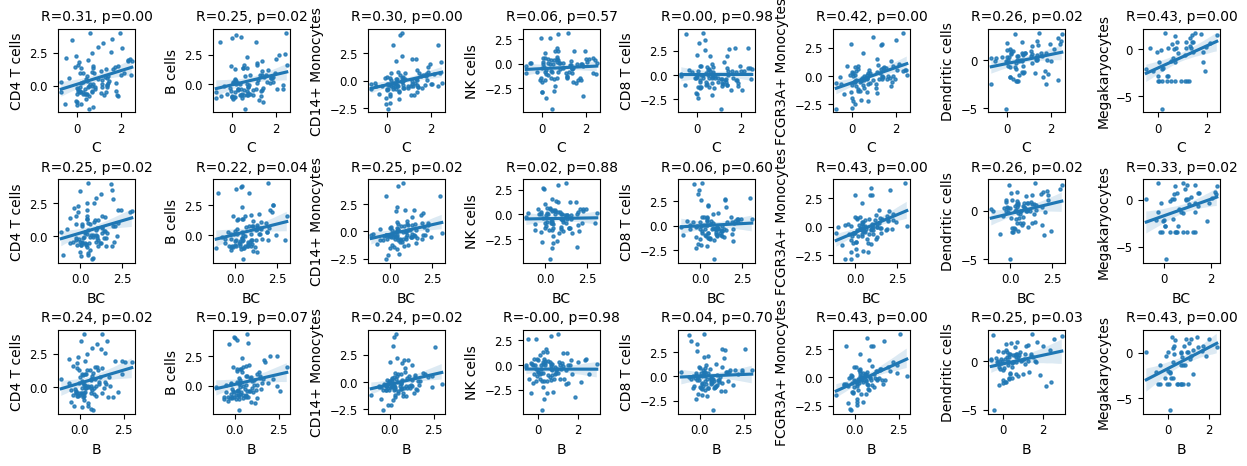

In [182]:
plt.figure(figsize=(15, 5));
plt.subplots_adjust(wspace=1, hspace=0.8)
idx=1
for c1, c2 in itertools.product(hbec_cts, pbmc_cts):
    
    plt.subplot(3, 8, idx)
    
    get_ct_correlation(isg_v, c1, c2)
    idx +=1 
plt.savefig('hbec_pbmc_varibilities.png', dpi=100, bbox_inches='tight')

In [157]:
len(list())

24

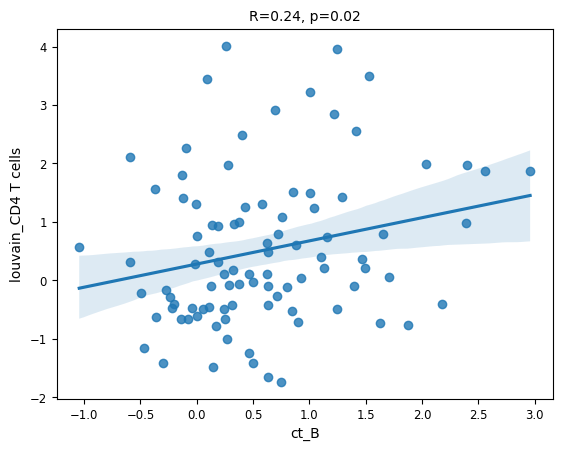

In [155]:
get_ct_correlation(isg_v, 'ct_B', 'louvain_CD4 T cells')

In [109]:
isg_v

,gene,cytokine,ifnb_isg,variable,value
2,ISG15,False,True,louvain_CD4 T cells,1.988591
58,IFI6,False,True,louvain_CD4 T cells,1.860306
142,IFI44L,False,True,louvain_CD4 T cells,1.850379
143,IFI44,False,True,louvain_CD4 T cells,-0.497812
152,GBP1,False,True,louvain_CD4 T cells,3.197121
335,CMPK2,False,True,louvain_CD4 T cells,0.638500
494,STAT1,False,True,louvain_CD4 T cells,0.082344
526,SP110,False,True,louvain_CD4 T cells,0.423761
644,PARP9,False,True,louvain_CD4 T cells,-0.765446
645,PARP14,False,True,louvain_CD4 T cells,0.274536
